In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

In [32]:
import tensorflow as tf

In [145]:
df=pd.read_excel('USCANCom.xlsx')

In [146]:
pd.set_option('display.max_colwidth', None)
df.head(1)

,Company Name,Primary Sector,Primary Industry,Business Description
0,@Plan.Inc,Industrials,Research and Consulting Services,"@Plan.Inc. was acquired by DoubleClick Inc. on February 2, 2001. @Plan.Inc. provided target market research planning systems for Internet advertisers, advertising agencies, Web publishers, online retailers, and consumer brand marketers."


In [147]:
df['Business Description'] = df['Business Description'].str.replace('[^\w\s]','')
df['Business Description'] = df['Business Description'].str.replace('\d+', '')
df['Business Description'] = df['Business Description'].astype(str)
df['Primary Sector'] = df['Primary Sector'].astype(str)
df['Primary Industry'] = df['Primary Industry'].str.replace('\d+', '')
df = df[['Primary Sector','Business Description']]
df = df[df['Primary Sector'].isin(['Financials','Materials','Information Technology', 'Health Care','Industrials','Consumer Discretionary', 'Energy','Communication Services'])]

In [148]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Business Description'] = df['Business Description'].apply(clean_text)

In [149]:
df['Primary Sector'].value_counts()

Financials                5245
Materials                 2906
Information Technology    2749
Health Care               2682
Industrials               2219
Consumer Discretionary    2014
Energy                    1918
Communication Services    1472
Name: Primary Sector, dtype: int64

In [150]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(df['Primary Sector']),
                                             df['Primary Sector']))

class_weights.sort()

weights={}

for index, weight in enumerate(class_weights) :
    
    weights[index]=weight
    
weights

C:\Users\jharu\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=['Communication Services' 'Consumer Discretionary' 'Energy' 'Financials'
 'Health Care' 'Industrials' 'Information Technology' 'Materials'], y=0                   Industrials
1        Information Technology
2        Consumer Discretionary
3        Consumer Discretionary
4                    Financials
                  ...          
21200    Communication Services
21201                 Materials
21202                 Materials
21203    Information Technology
21204    Consumer Discretionary
Name: Primary Sector, Length: 21205, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 0.5053622497616778,
 1: 0.9121214728148658,
 2: 0.9642142597308112,
 3: 0.9883016405667412,
 4: 1.1945132942767012,
 5: 1.316099801390268,
 6: 1.381973409801877,
 7: 1.800696331521739}

In [157]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Business Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 66256 unique tokens.


In [158]:
word_index

{'inc': 1,
 'company': 2,
 'services': 3,
 'products': 4,
 'provides': 5,
 'offers': 6,
 'based': 7,
 'loans': 8,
 'founded': 9,
 'acquired': 10,
 'canada': 11,
 'corp': 12,
 'headquartered': 13,
 'also': 14,
 'corporation': 15,
 'well': 16,
 'operates': 17,
 'merger': 18,
 'transaction': 19,
 'development': 20,
 'commercial': 21,
 'united': 22,
 'states': 23,
 'reverse': 24,
 'business': 25,
 'name': 26,
 'management': 27,
 'formerly': 28,
 'systems': 29,
 'solutions': 30,
 'known': 31,
 'changed': 32,
 'including': 33,
 'incorporated': 34,
 'bank': 35,
 'various': 36,
 'eploration': 37,
 'new': 38,
 'engages': 39,
 'oil': 40,
 'financial': 41,
 'gas': 42,
 'energy': 43,
 'ltd': 44,
 'banking': 45,
 'located': 46,
 'properties': 47,
 'technology': 48,
 'accounts': 49,
 'group': 50,
 'acquisition': 51,
 'real': 52,
 'segment': 53,
 'include': 54,
 'resources': 55,
 'capital': 56,
 'equipment': 57,
 'estate': 58,
 'markets': 59,
 'gold': 60,
 'operations': 61,
 'primarily': 62,
 'softwa

In [159]:
X = tokenizer.texts_to_sequences(df['Business Description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (21205, 200)


In [160]:
X[2000]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0, 25839,     1,     5, 13252,   335,  1559,    30,  2183,
          30,   169,   538,    57,  4603,   650,     3,   153,   565,
         714,   144,  1352,    72,    59,     2,    17,   186,   133,
          43,   335,   891,    43,    53,     5,   610,     4,     3,
         397,   148,    72,   538,  1351,    87,     6,   406, 12961,
         538,  2389,   623,   343,  2118,  2329,  9567, 10460,  4786,
        1738,  1927,   624,  1351, 15330,    57,  2862,     4,  3431,
         107,   136,

In [161]:
Y = pd.get_dummies(df['Primary Sector']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (21205, 8)


In [162]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 142)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(18024, 200) (18024, 8)
(3181, 200) (3181, 8)


In [163]:
model = tf.keras.Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
#model.add(tf.keras.layers.Reshape( target_shape=(128 , 1 ) ))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
for units in [128, 64 ]:
    
    model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 200, 128)          6400000   
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 200, 256)          263168    
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)              

In [165]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [166]:
epochs = 1
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs,class_weight=weights, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)])

254/254 [==============================] - 944s 4s/step - loss: 1.5103 - accuracy: 0.5113 - val_loss: 1.1161 - val_accuracy: 0.6334


In [35]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

67/67 [==============================] - 7s 109ms/step - loss: 1.0797 - accuracy: 0.7181
Test set
  Loss: 1.080
  Accuracy: 0.718


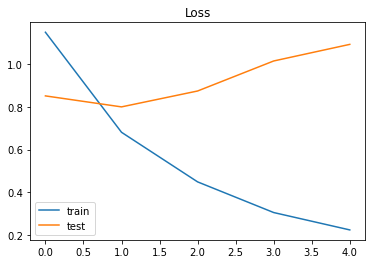

In [36]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [37]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[1.34135786e-04 3.46980523e-05 2.78926091e-05 9.98372912e-01
  9.41175458e-05 3.11064709e-04 9.08900925e-04 1.16167575e-04]] Credit card or prepaid card


In [49]:
df['Primary Sector'].value_counts()

Financials                5245
Materials                 2906
Information Technology    2749
Health Care               2682
Industrials               2219
Consumer Discretionary    2014
Energy                    1918
Communication Services    1472
Name: Primary Sector, dtype: int64

In [54]:
new_complaint = ['develops, installs, and sells software for shoppers and retailers in the United States. Its platform includes 12Mirror, an in-store application, which recognizes clothes worn by a person in reflection and takes pictures that are downloadable by the user and sharable via social media; 12Kiosk, an in-store application, used for browsing and obtaining information about consumers and products, as well as placing orders and checking out; 12Mobile, a mobile app, used for browse products, place orders, and share products with other members and make new friends; and 12Desktop, an e-commerce website that can be developed upon request. The company also operates eight retail outlets that sell electronics and travel-related products at the United States airport and casino locations under our Bluwire brand name; creates and sells fashionable apparel under our Rune NYC, Social Sunday, Emotion Fashion, and Lexi-Lu brands; and produces clothing and travel accessories. 12 ReTech Corporation is based in Phoenix, Arizona.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Financials','Materials','Information Technology', 'Health Care','Industrials','Consumer Discretionary', 'Energy','Communication Services']
print(pred, labels[np.argmax(pred)])

[[2.0869078e-02 9.6113646e-01 2.1294011e-03 3.7346786e-04 7.3865056e-03
  6.8867044e-03 9.1605238e-04 3.0229325e-04]] Materials


In [42]:
y_pred=model.predict(X_test)

In [43]:
from sklearn.metrics import classification_report

In [46]:
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.45      0.61      0.52       136
           1       0.57      0.57      0.57       197
           2       0.88      0.80      0.84       193
           3       0.83      0.84      0.84       529
           4       0.83      0.82      0.82       290
           5       0.45      0.43      0.44       202
           6       0.63      0.56      0.59       273
           7       0.81      0.84      0.83       301

    accuracy                           0.72      2121
   macro avg       0.68      0.68      0.68      2121
weighted avg       0.72      0.72      0.72      2121

